## Cell 1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)
plt.rcParams.update({
    "figure.dpi": 130,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

print("✅ Libraries loaded successfully.")

✅ Libraries loaded successfully.


## Cell 2 — Upload & Load Dataset

In [2]:
from google.colab import files

print("📂 Please select and upload your 'cars_price.csv' file ...")
uploaded = files.upload()


DATA_PATH = list(uploaded.keys())[0]
df_raw = pd.read_csv(DATA_PATH)

print(f"\n✅ File '{DATA_PATH}' loaded successfully!")
print(f"   Shape : {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"   Columns: {df_raw.columns.tolist()}")
print("\n--- First 5 rows ---")
df_raw.head()

📂 Please select and upload your 'cars_price.csv' file ...


Saving cars_price.csv to cars_price.csv

✅ File 'cars_price.csv' loaded successfully!
   Shape : 8,128 rows × 12 columns
   Columns: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats']

--- First 5 rows ---


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


## Cell 3 — Data Preprocessing & Cleaning

In [18]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()


    df.columns = df.columns.str.strip()


    df.rename(columns={"mileage(km/ltr/kg)": "mileage"}, inplace=True);


    df["max_power"] = pd.to_numeric(df["max_power"], errors="coerce")


    critical = ["selling_price", "km_driven", "mileage", "engine",
                    "max_power", "seats"]
    rows_before = len(df)
    df.dropna(subset=critical, inplace=True)
    print(f"  ✂  Rows dropped (missing values)  : {rows_before - len(df)}")


    Q1  = df["selling_price"].quantile(0.25)
    Q3  = df["selling_price"].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    rows_before_iqr = len(df)
    df = df[df["selling_price"].between(lower_fence, upper_fence)]
    print(f"  ✂  Rows dropped (price outliers)   : {rows_before_iqr - len(df)}")
    print(f"     Price range after cleaning       : ₹{df['selling_price'].min():,} – ₹{df['selling_price'].max():,}")


    df["car_age"] = 2020 - df["year"]


    df["brand"] = df["name"].str.split().str[0]


    df["seats"] = df["seats"].astype(int)

    print(f"\n✅ Preprocessing complete — final shape: {df.shape}")
    return df


df = preprocess_data(df_raw)


print("\nNull check on cleaned dataset:")
null_summary = df.isnull().sum()
print(null_summary[null_summary > 0].to_string() if null_summary.sum() > 0 else "  → No missing values remaining!")

df.head()

  ✂  Rows dropped (missing values)  : 222
  ✂  Rows dropped (price outliers)   : 598
     Price range after cleaning       : ₹29,999 – ₹1,300,000

✅ Preprocessing complete — final shape: (7308, 14)

Null check on cleaned dataset:
  → No missing values remaining!


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_age,brand
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5,6,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5,6,Skoda
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5,14,Honda
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5,10,Hyundai
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5,13,Maruti


## Cell 4 — Descriptive Statistics

In [19]:
def show_descriptive_statistics(df: pd.DataFrame) -> pd.DataFrame:

    num_cols = df.select_dtypes(include=np.number).columns.tolist()

    stats = df[num_cols].describe().T
    stats["skewness"] = df[num_cols].skew().round(2)
    stats["kurtosis"] = df[num_cols].kurtosis().round(2)
    stats = stats.round(2)

    print("=" * 65)
    print("  NUMERIC DESCRIPTIVE STATISTICS")
    print("=" * 65)
    display(stats)

    print("\n" + "=" * 65)
    print("  CATEGORICAL VALUE COUNTS")
    print("=" * 65)
    for col in ["fuel", "seller_type", "transmission", "owner"]:
        counts = df[col].value_counts()
        pct    = (counts / len(df) * 100).round(1)
        summary = pd.DataFrame({"Count": counts, "Pct %": pct})
        print(f"\n▶ {col.upper()}")
        display(summary)

    return stats


stats_df = show_descriptive_statistics(df)

  NUMERIC DESCRIPTIVE STATISTICS


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
year,7308.0,2013.72,3.86,1994.0,2011.0,2014.00,2017.00,2020.00,-0.95,1.22
selling_price,7308.0,459898.51,257212.53,29999.0,250000.0,425000.00,625000.00,1300000.00,0.67,0.06
km_driven,7308.0,71882.89,57564.06,1.0,35000.0,65000.00,100000.00,2360457.00,11.68,396.24
mileage,7308.0,19.68,3.97,0.0,17.0,19.70,22.54,33.44,-0.17,0.43
engine,7308.0,1395.56,456.71,624.0,1197.0,1248.00,1498.00,3498.00,1.30,1.30
max_power,7308.0,84.62,25.61,32.8,68.0,81.83,98.60,272.00,1.17,2.92
seats,7308.0,5.41,0.96,2.0,5.0,5.00,5.00,14.00,2.04,4.18
car_age,7308.0,6.28,3.86,0.0,3.0,6.00,9.00,26.00,0.95,1.22



  CATEGORICAL VALUE COUNTS

▶ FUEL


,Count,Pct %
fuel,,
Diesel,3817,52.2
Petrol,3404,46.6
CNG,52,0.7
LPG,35,0.5



▶ SELLER_TYPE


,Count,Pct %
seller_type,,
Individual,6330,86.6
Dealer,774,10.6
Trustmark Dealer,204,2.8



▶ TRANSMISSION


,Count,Pct %
transmission,,
Manual,6745,92.3
Automatic,563,7.7



▶ OWNER


,Count,Pct %
owner,,
First Owner,4674,64.0
Second Owner,1967,26.9
Third Owner,507,6.9
Fourth & Above Owner,160,2.2


## Cell 5 — Correlation Heatmap (Statistical Plot)

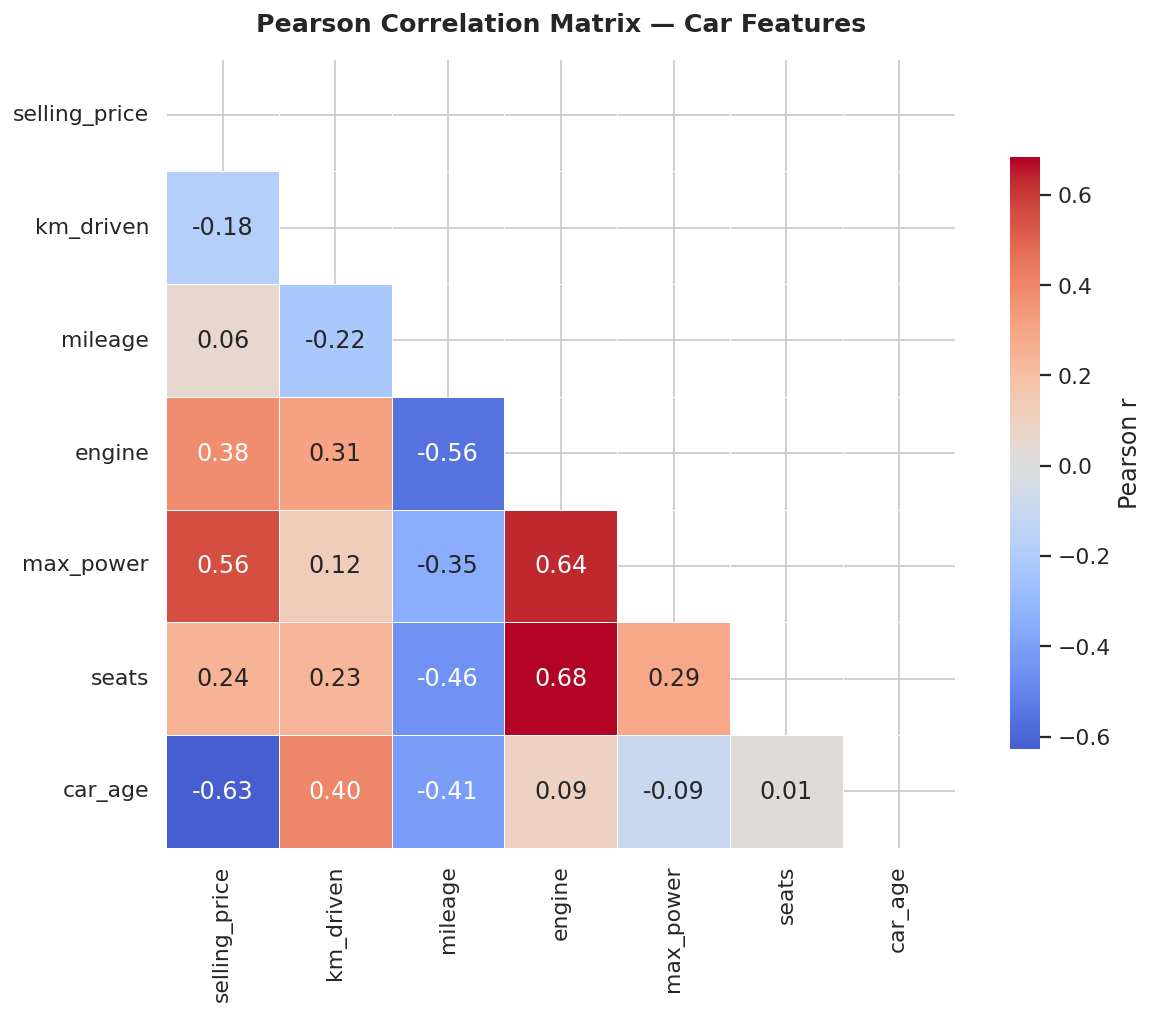

  💾 Saved → plot_01_correlation_heatmap.png


In [20]:
def plot_correlation_heatmap(df: pd.DataFrame,
                              save_path: str = "plot_01_correlation_heatmap.png") -> None:

    num_df = df.select_dtypes(include=np.number).drop(columns=["year"])
    corr   = num_df.corr()


    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        linecolor="white",
        square=True,
        cbar_kws={"shrink": 0.75, "label": "Pearson r"},
        ax=ax,
    )
    ax.set_title("Pearson Correlation Matrix — Car Features",
                 fontsize=14, fontweight="bold", pad=15)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_correlation_heatmap(df)

## Cell 6 — Selling Price Distribution (Statistical Plot)

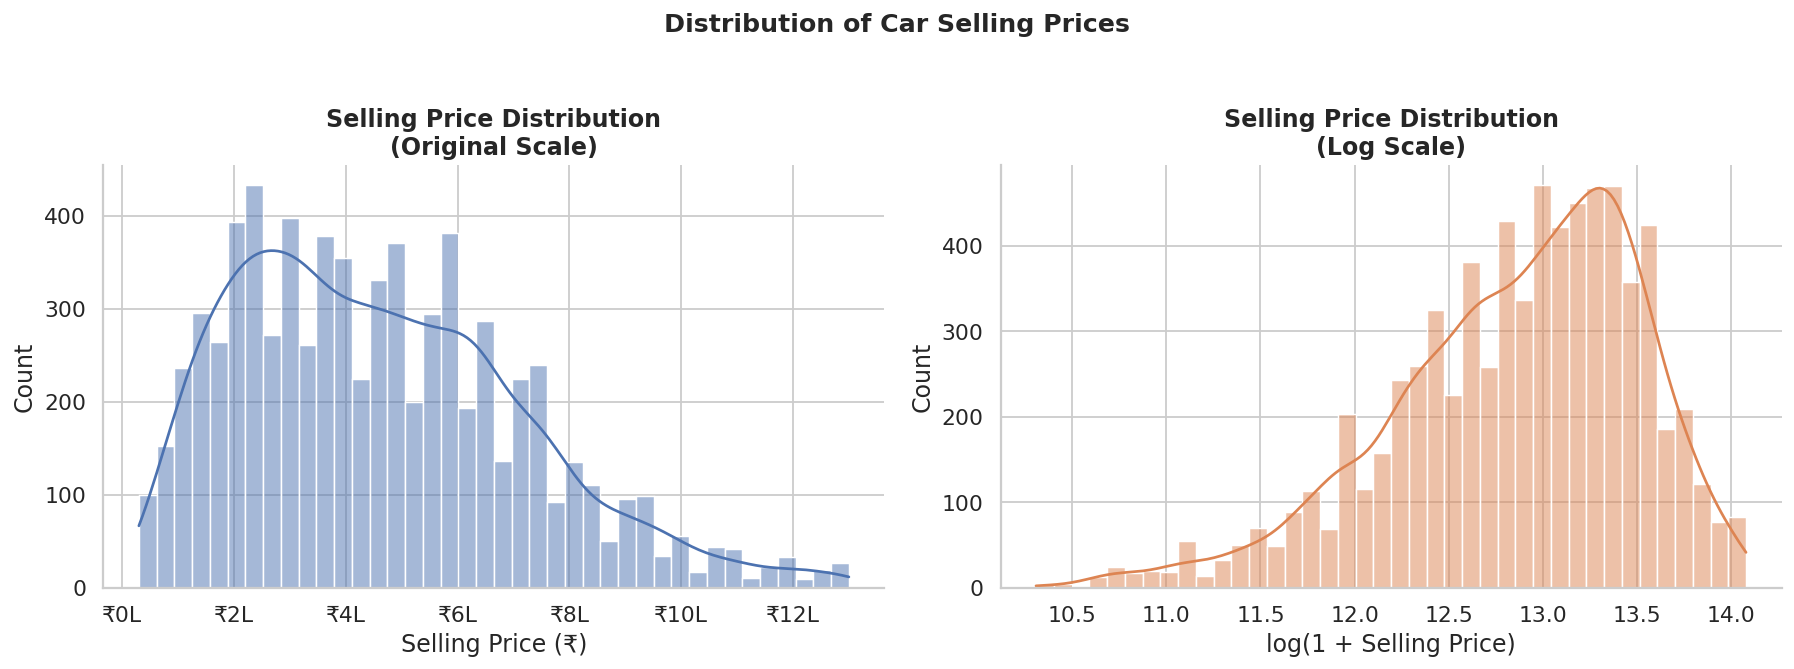

  💾 Saved → plot_02_price_distribution.png


In [21]:
def plot_price_distribution(df: pd.DataFrame,
                             save_path: str = "plot_02_price_distribution.png") -> None:

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))


    sns.histplot(df["selling_price"], bins=40, kde=True,
                 color="#4C72B0", edgecolor="white", ax=axes[0])
    axes[0].set_title("Selling Price Distribution\n(Original Scale)",
                      fontweight="bold")
    axes[0].set_xlabel("Selling Price (₹)")
    axes[0].set_ylabel("Count")
    axes[0].xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))


    sns.histplot(np.log1p(df["selling_price"]), bins=40, kde=True,
                 color="#DD8452", edgecolor="white", ax=axes[1])
    axes[1].set_title("Selling Price Distribution\n(Log Scale)",
                      fontweight="bold")
    axes[1].set_xlabel("log(1 + Selling Price)")
    axes[1].set_ylabel("Count")

    fig.suptitle("Distribution of Car Selling Prices",
                 fontsize=14, fontweight="bold", y=1.03)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_price_distribution(df)

## Cell 7 — Engine Size vs Selling Price (Relational Plot)

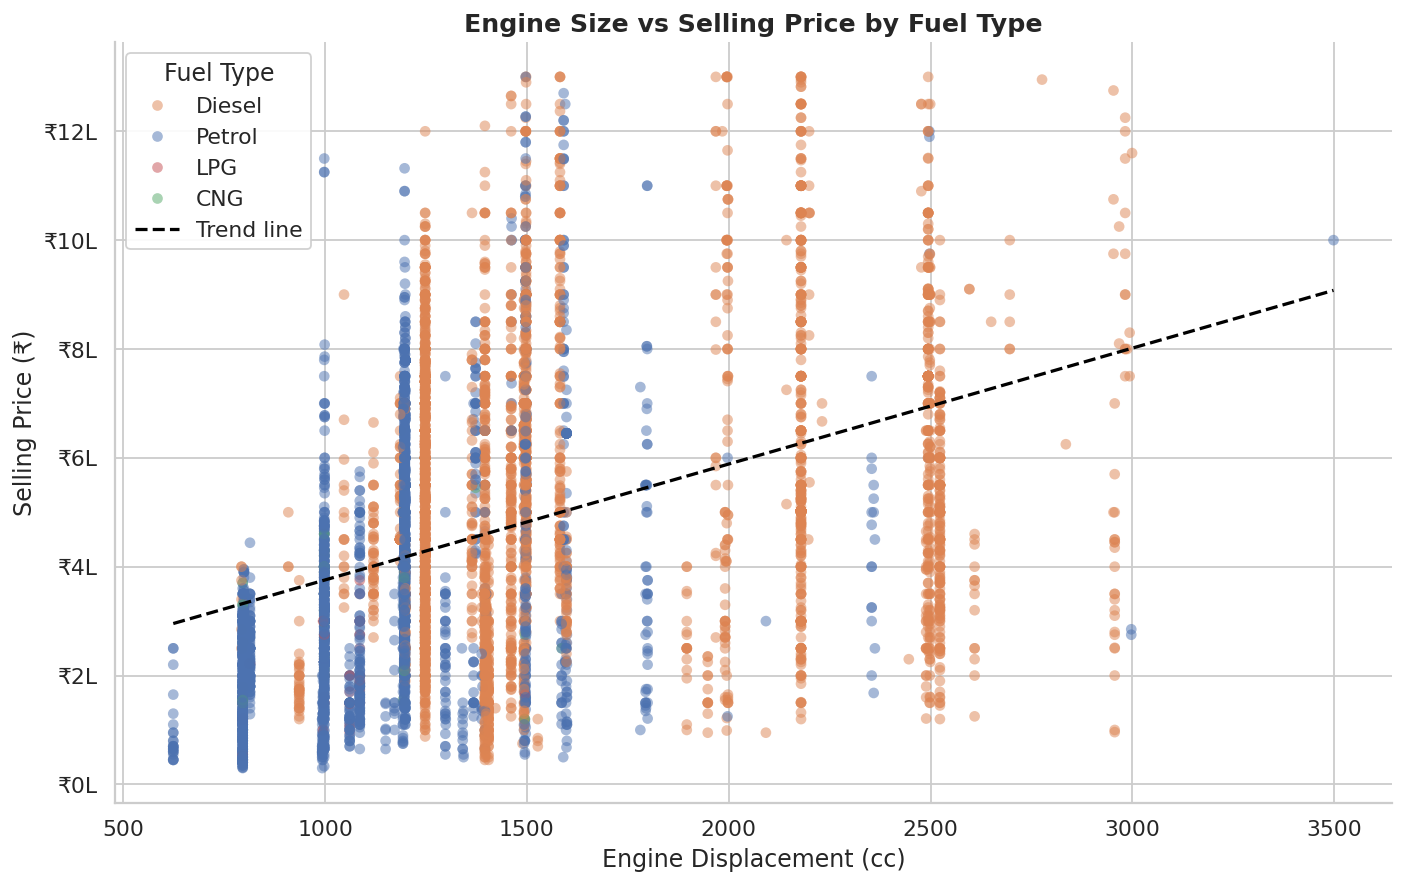

  💾 Saved → plot_03_engine_vs_price.png


In [22]:
def plot_engine_vs_price(df: pd.DataFrame,
                          save_path: str = "plot_03_engine_vs_price.png") -> None:

    fuel_palette = {
        "Petrol":  "#4C72B0",
        "Diesel":  "#DD8452",
        "CNG":     "#55A868",
        "LPG":     "#C44E52",
    }

    fig, ax = plt.subplots(figsize=(11, 7))

    sns.scatterplot(
        data=df,
        x="engine",
        y="selling_price",
        hue="fuel",
        palette=fuel_palette,
        alpha=0.5,
        s=35,
        edgecolor="none",
        ax=ax,
    )


    m, b = np.polyfit(df["engine"], df["selling_price"], 1)
    x_range = np.linspace(df["engine"].min(), df["engine"].max(), 300)
    ax.plot(x_range, m * x_range + b,
            color="black", linewidth=1.8, linestyle="--", label="Trend line")

    ax.set_title("Engine Size vs Selling Price by Fuel Type",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Engine Displacement (cc)")
    ax.set_ylabel("Selling Price (₹)")
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))
    ax.legend(title="Fuel Type", framealpha=0.9)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_engine_vs_price(df)

## Cell 8 — Kilometres Driven vs Selling Price (Relational Plot)

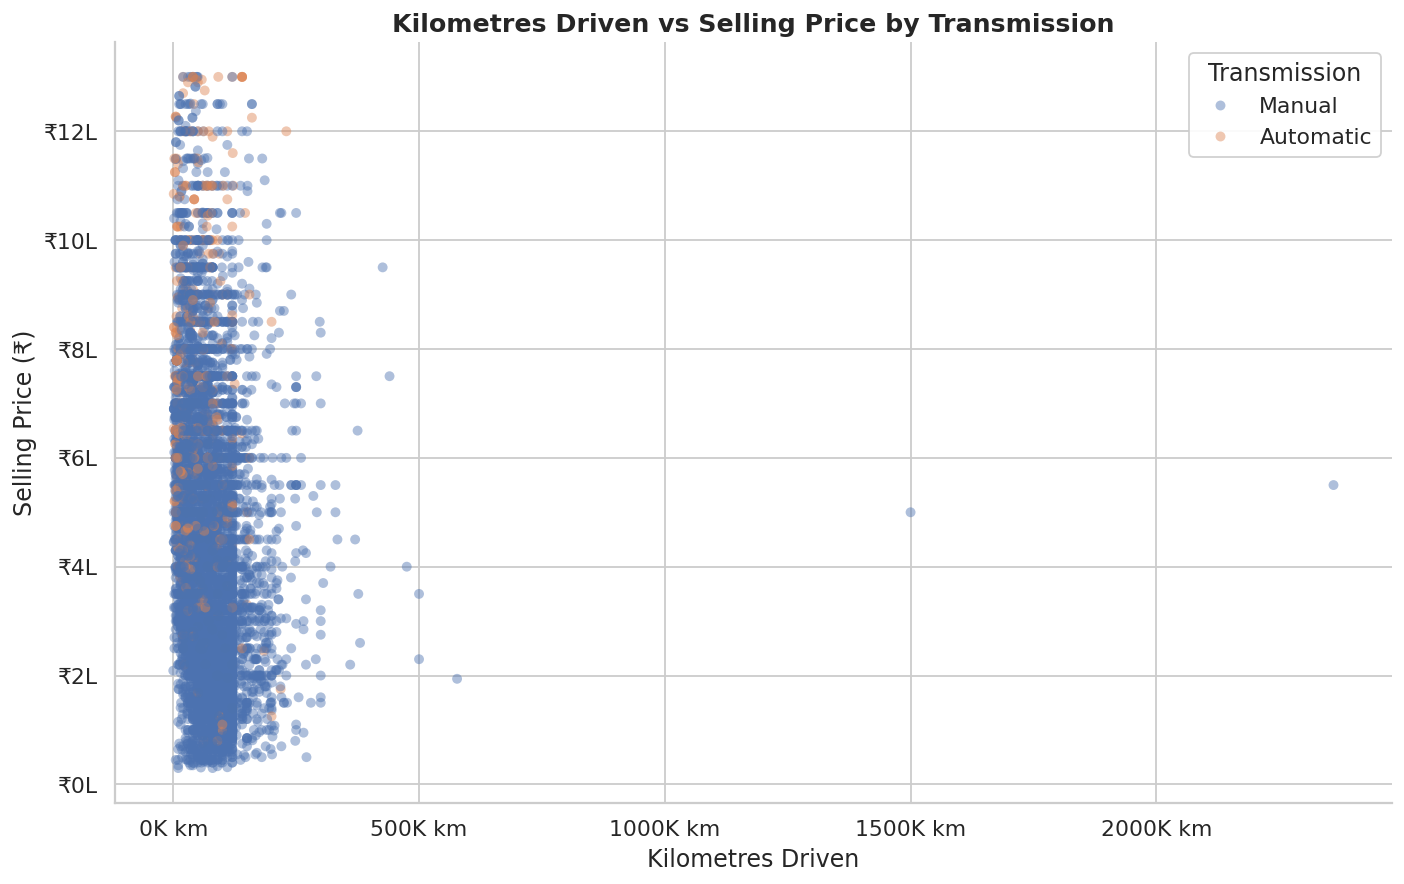

  💾 Saved → plot_04_km_vs_price.png


In [23]:
def plot_km_vs_price(df: pd.DataFrame,
                      save_path: str = "plot_04_km_vs_price.png") -> None:

    fig, ax = plt.subplots(figsize=(11, 7))

    sns.scatterplot(
        data=df,
        x="km_driven",
        y="selling_price",
        hue="transmission",
        palette={"Manual": "#4C72B0", "Automatic": "#DD8452"},
        alpha=0.45,
        s=30,
        edgecolor="none",
        ax=ax,
    )

    ax.set_title("Kilometres Driven vs Selling Price by Transmission",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Kilometres Driven")
    ax.set_ylabel("Selling Price (₹)")
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}K km"))
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))
    ax.legend(title="Transmission", framealpha=0.9)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_km_vs_price(df)

## Cell 9 — Selling Price by Fuel Type (Categorical Plot)

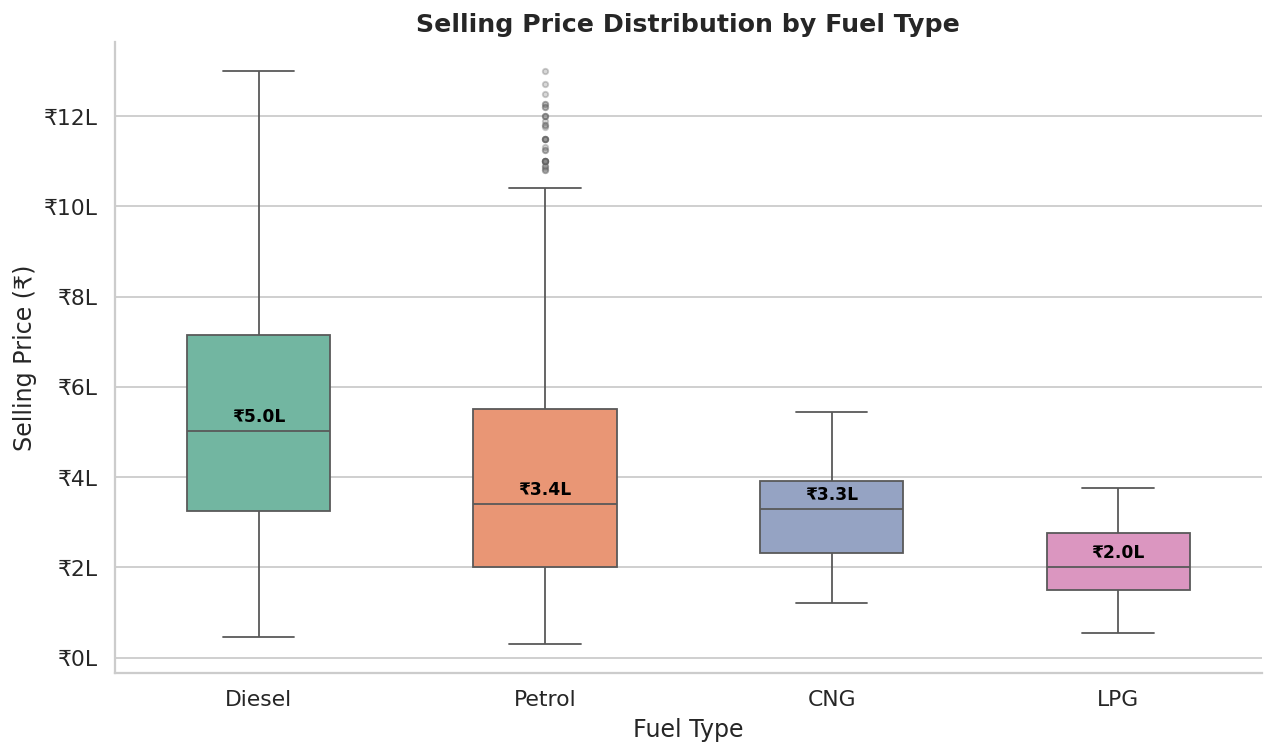

  💾 Saved → plot_05_fuel_price_boxplot.png


In [24]:
def plot_fuel_price_boxplot(df: pd.DataFrame,
                             save_path: str = "plot_05_fuel_price_boxplot.png") -> None:

    order = (df.groupby("fuel")["selling_price"]
               .median()
               .sort_values(ascending=False)
               .index.tolist())

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        data=df,
        x="fuel",
        y="selling_price",
        order=order,
        palette="Set2",
        width=0.5,
        flierprops=dict(marker="o", markersize=3, alpha=0.3,
                        markerfacecolor="grey", linestyle="none"),
        ax=ax,
    )

    ax.set_title("Selling Price Distribution by Fuel Type",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Fuel Type")
    ax.set_ylabel("Selling Price (₹)")
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))


    medians = df.groupby("fuel")["selling_price"].median().reindex(order)
    for i, (fuel, med) in enumerate(medians.items()):
        ax.text(i, med + 12000, f"₹{med/1e5:.1f}L",
                ha="center", va="bottom", fontsize=9.5,
                fontweight="bold", color="black")

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_fuel_price_boxplot(df)

## Cell 10 — Average Price by Seller Type (Categorical Plot)

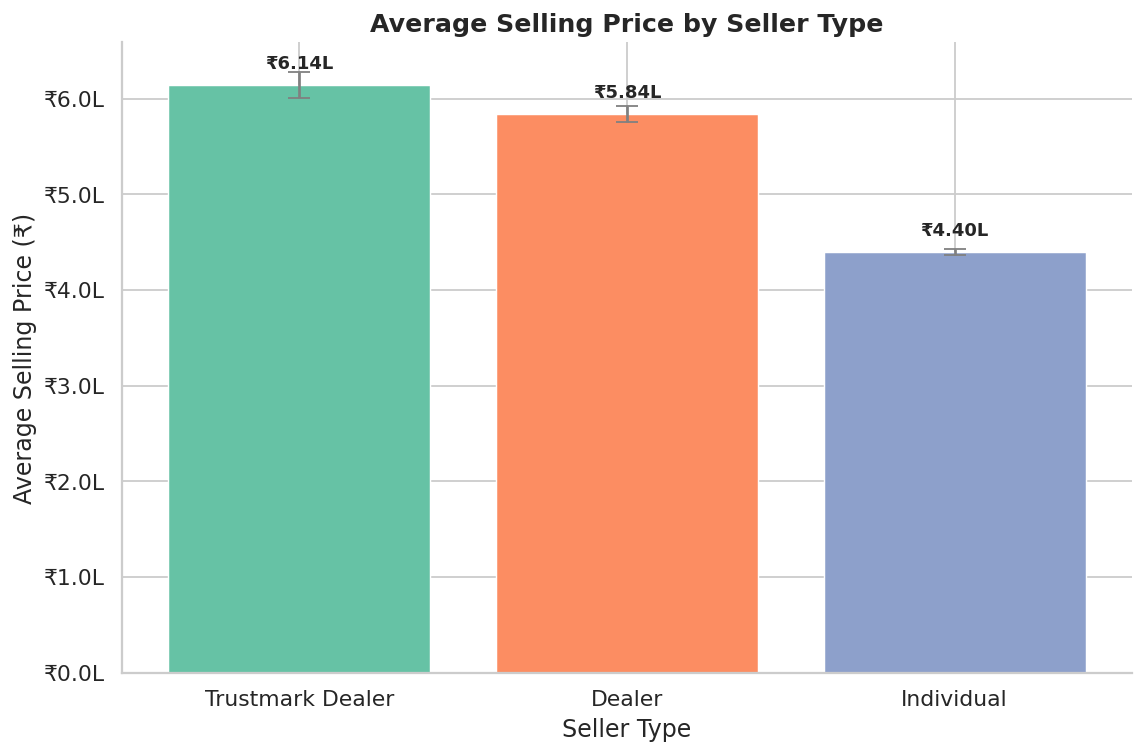

  💾 Saved → plot_06_avg_price_seller.png


In [25]:
def plot_avg_price_by_seller(df: pd.DataFrame,
                              save_path: str = "plot_06_avg_price_seller.png") -> None:

    seller_stats = (
        df.groupby("seller_type")["selling_price"]
          .agg(mean="mean", sem=lambda x: x.sem())
          .reset_index()
          .sort_values("mean", ascending=False)
    )

    fig, ax = plt.subplots(figsize=(9, 6))
    colors = sns.color_palette("Set2", len(seller_stats))

    bars = ax.bar(
        seller_stats["seller_type"],
        seller_stats["mean"],
        yerr=seller_stats["sem"],
        capsize=6,
        color=colors,
        edgecolor="white",
        linewidth=0.8,
        error_kw={"elinewidth": 1.5, "ecolor": "grey"},
    )

    ax.set_title("Average Selling Price by Seller Type",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Seller Type")
    ax.set_ylabel("Average Selling Price (₹)")
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.1f}L"))


    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"₹{h/1e5:.2f}L",
                    xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 7), textcoords="offset points",
                    ha="center", va="bottom",
                    fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_avg_price_by_seller(df)

## Cell 11 — Count of Listings by Fuel Type (Categorical Plot)

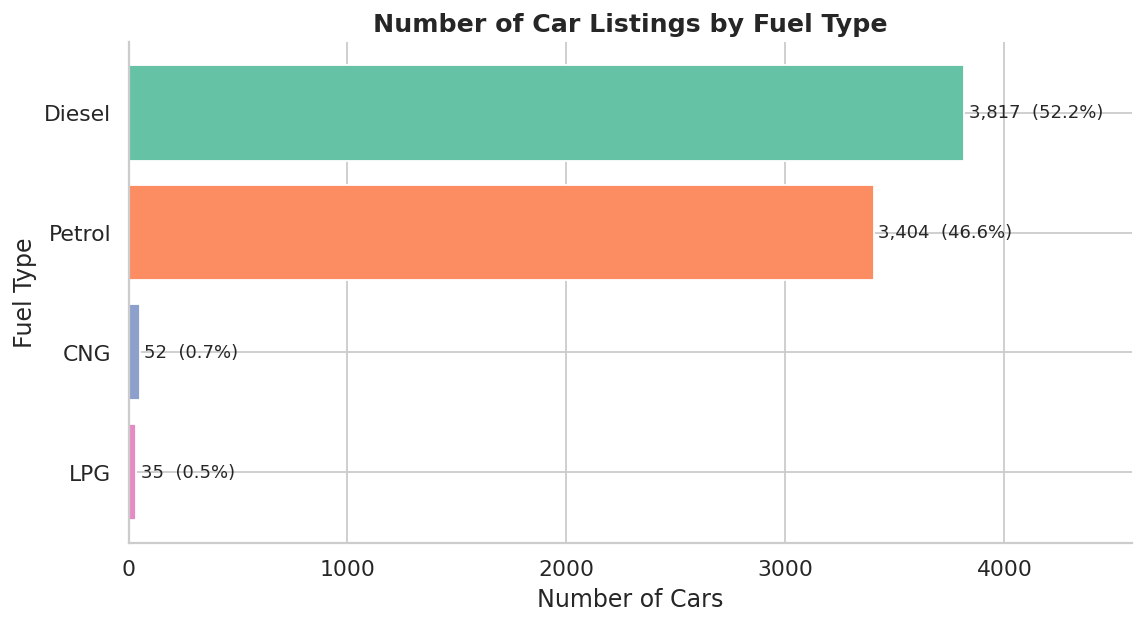

  💾 Saved → plot_07_fuel_count.png


In [26]:
def plot_fuel_count(df: pd.DataFrame,
                     save_path: str = "plot_07_fuel_count.png") -> None:

    counts = df["fuel"].value_counts().reset_index()
    counts.columns = ["fuel", "count"]
    total  = counts["count"].sum()
    counts["pct"] = (counts["count"] / total * 100).round(1);

    fig, ax = plt.subplots(figsize=(9, 5))
    colors = sns.color_palette("Set2", len(counts))

    bars = ax.barh(counts["fuel"], counts["count"],
                   color=colors, edgecolor="white")

    ax.set_title("Number of Car Listings by Fuel Type",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Number of Cars")
    ax.set_ylabel("Fuel Type")
    ax.invert_yaxis()


    for bar, (_, row) in zip(bars, counts.iterrows()):
        w = bar.get_width()
        ax.text(w + 20, bar.get_y() + bar.get_height() / 2,
                f"{int(w):,}  ({row['pct']}%)",
                va="center", ha="left", fontsize=10);

    ax.set_xlim(0, counts["count"].max() * 1.2)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_fuel_count(df)

## Cell 12 — Price Distribution: Manual vs Automatic (Statistical Plot)

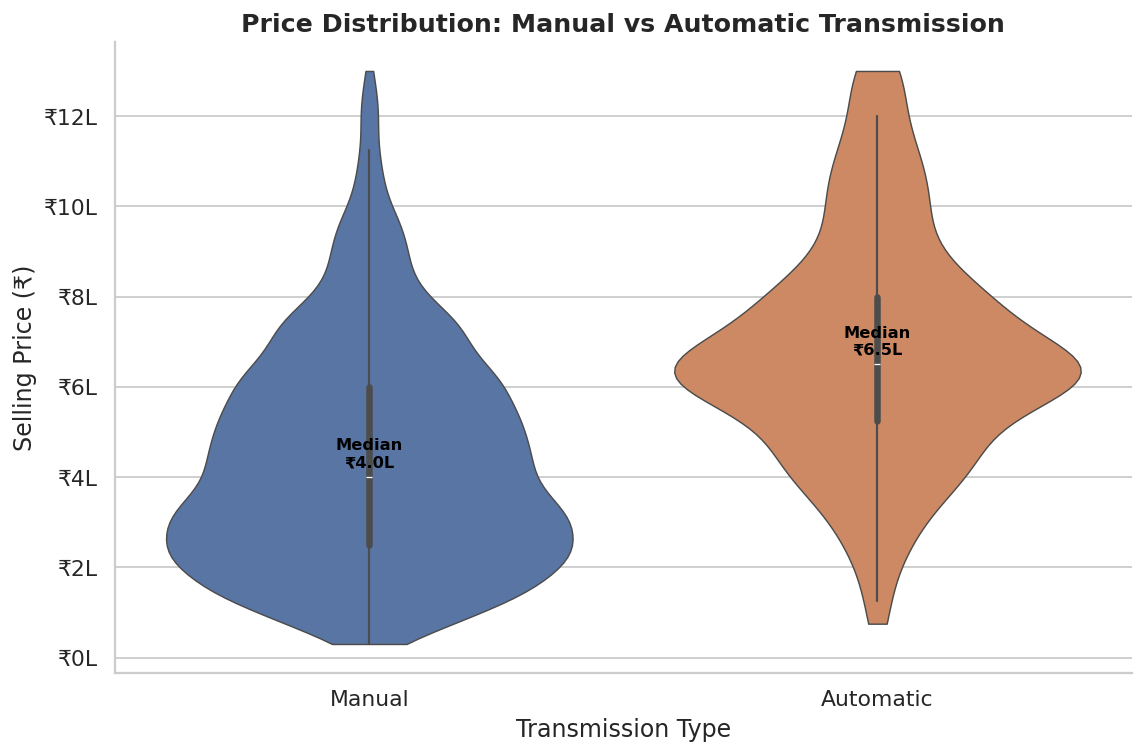

  💾 Saved → plot_08_transmission_violin.png


In [27]:
def plot_transmission_violin(df: pd.DataFrame,
                              save_path: str = "plot_08_transmission_violin.png") -> None:

    fig, ax = plt.subplots(figsize=(9, 6))

    sns.violinplot(
        data=df,
        x="transmission",
        y="selling_price",
        palette={"Manual": "#4C72B0", "Automatic": "#DD8452"},
        inner="box",
        cut=0,
        linewidth=0.8,
        ax=ax,
    )

    ax.set_title("Price Distribution: Manual vs Automatic Transmission",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Transmission Type")
    ax.set_ylabel("Selling Price (₹)")
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))


    for i, trans in enumerate(["Manual", "Automatic"]):
        med = df[df["transmission"] == trans]["selling_price"].median()
        ax.text(i, med + 15000, f"Median\n₹{med/1e5:.1f}L",
                ha="center", va="bottom", fontsize=9,
                fontweight="bold", color="black")

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_transmission_violin(df)

## Cell 13 — Price Depreciation by Car Age (Relational Plot)

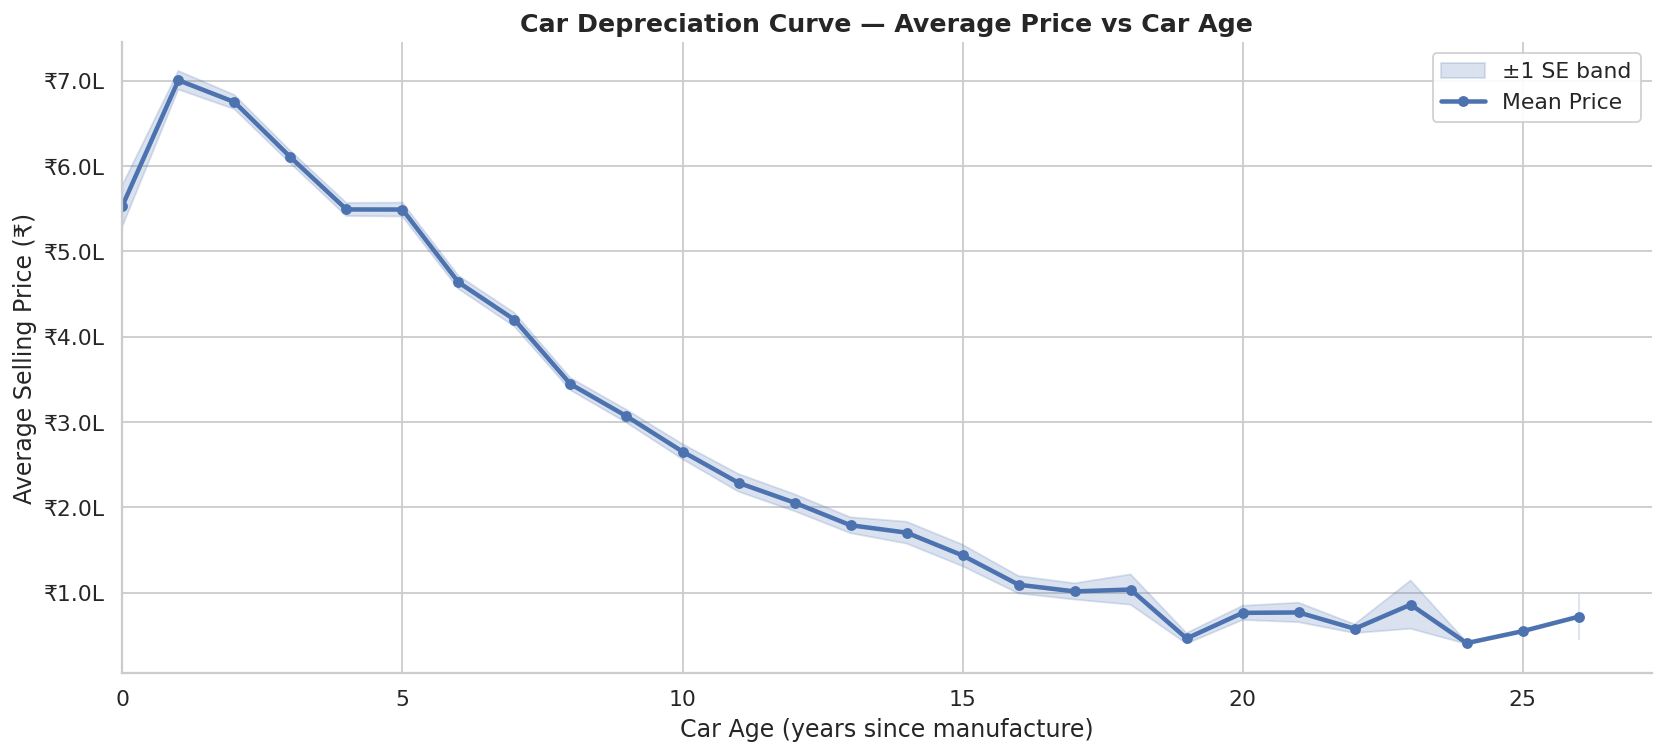

  💾 Saved → plot_09_depreciation_curve.png


In [28]:
def plot_depreciation_curve(df: pd.DataFrame,
                             save_path: str = "plot_09_depreciation_curve.png") -> None:

    age_stats = (
        df.groupby("car_age")["selling_price"]
          .agg(mean="mean", sem=lambda x: x.sem())
          .reset_index()
    )

    fig, ax = plt.subplots(figsize=(13, 6))


    ax.fill_between(age_stats["car_age"],
                    age_stats["mean"] - age_stats["sem"],
                    age_stats["mean"] + age_stats["sem"],
                    alpha=0.20, color="#4C72B0", label="±1 SE band")


    ax.plot(age_stats["car_age"], age_stats["mean"],
            color="#4C72B0", linewidth=2.5,
            marker="o", markersize=5, label="Mean Price")

    ax.set_title("Car Depreciation Curve — Average Price vs Car Age",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Car Age (years since manufacture)")
    ax.set_ylabel("Average Selling Price (₹)")
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.1f}L"))
    ax.legend(framealpha=0.9)
    ax.set_xlim(left=0)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_depreciation_curve(df)

## Cell 14 — Top 10 Brands by Median Price (Categorical Plot)

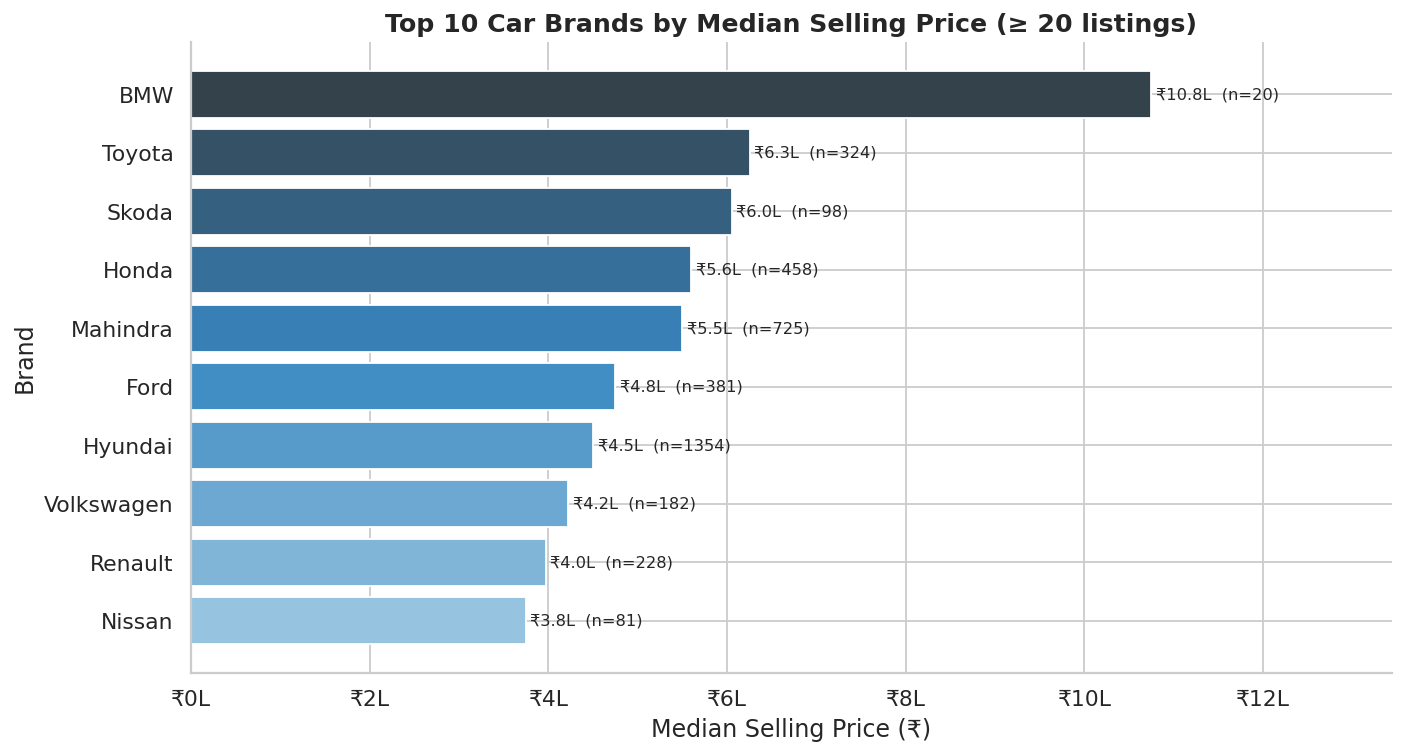

  💾 Saved → plot_10_top_brands.png


In [29]:
def plot_top_brands_by_price(df: pd.DataFrame,
                              top_n: int = 10,
                              save_path: str = "plot_10_top_brands.png") -> None:

    brand_stats = (
        df.groupby("brand")["selling_price"]
          .agg(median="median", count="count")
          .query("count >= 20")
          .sort_values("median", ascending=False)
          .head(top_n)
          .reset_index()
    )


    brand_stats = brand_stats[::-1].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(11, 6))
    palette  = sns.color_palette("Blues_d", top_n)

    bars = ax.barh(brand_stats["brand"], brand_stats["median"],
                   color=palette, edgecolor="white")

    ax.set_title(f"Top {top_n} Car Brands by Median Selling Price (≥ 20 listings)",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Median Selling Price (₹)")
    ax.set_ylabel("Brand")
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"₹{x/1e5:.0f}L"))


    for bar, (_, row) in zip(bars, brand_stats.iterrows()):
        w = bar.get_width()
        ax.text(w + 5000, bar.get_y() + bar.get_height() / 2,
                f"₹{w/1e5:.1f}L  (n={int(row['count'])})",
                va="center", ha="left", fontsize=9);

    ax.set_xlim(0, brand_stats["median"].max() * 1.25)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_top_brands_by_price(df)

## Cell 15 — Pair Plot of Key Features (Statistical Plot)

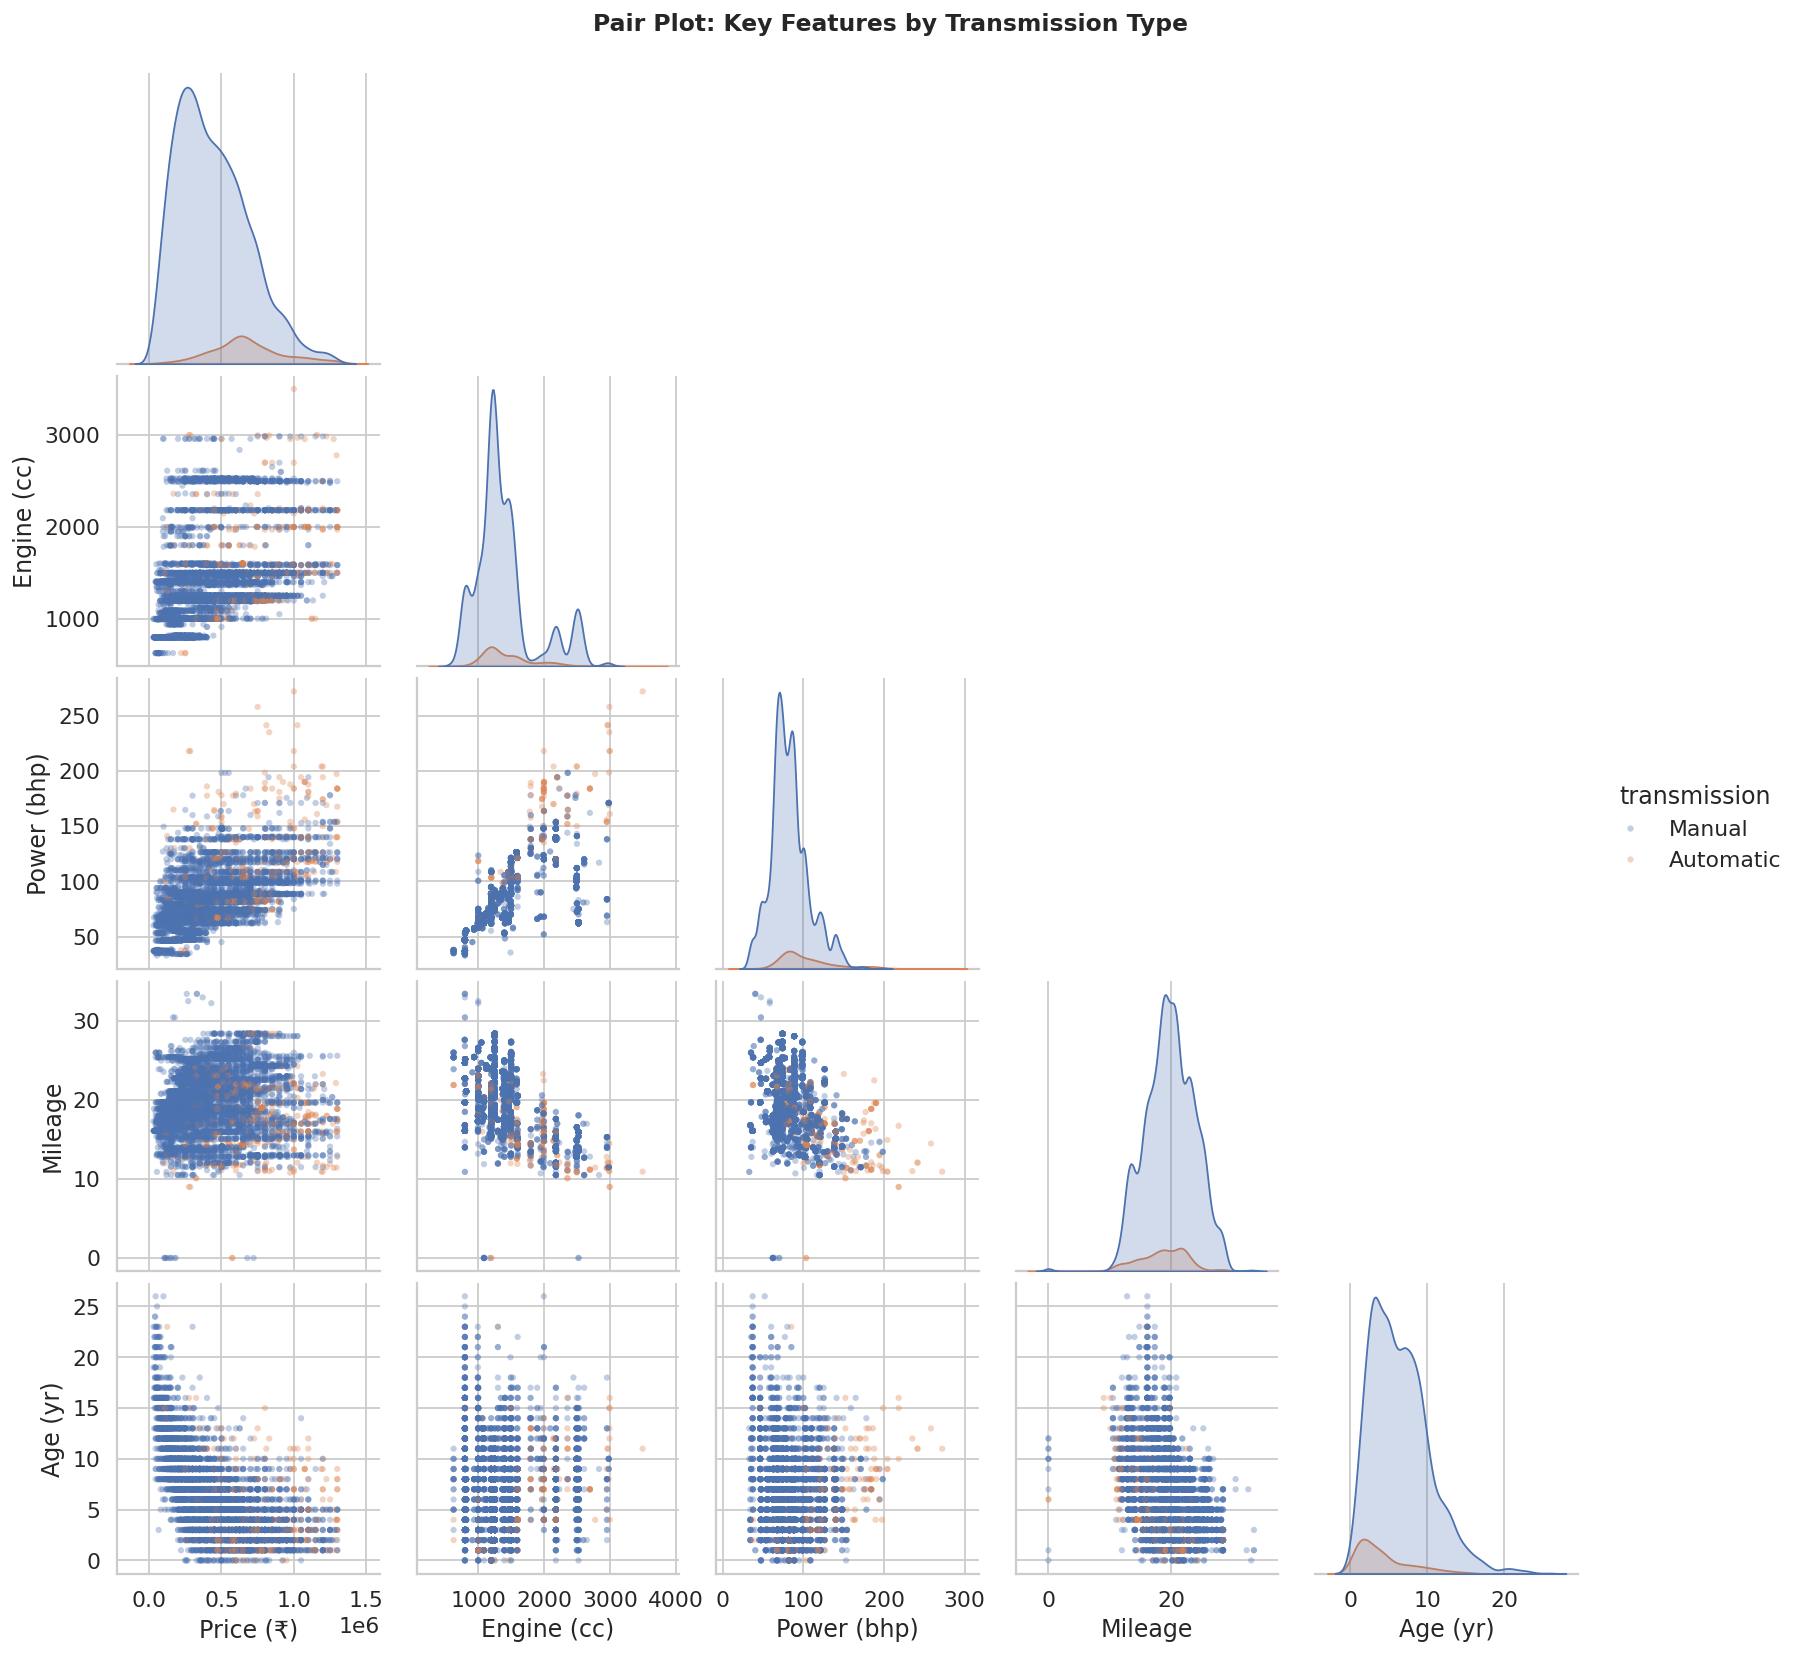

  💾 Saved → plot_11_pairplot.png


In [30]:
def plot_pairplot(df: pd.DataFrame,
                  save_path: str = "plot_11_pairplot.png") -> None:

    subset = df[["selling_price", "engine", "max_power",
                 "mileage", "car_age", "transmission"]].copy()

    subset.rename(columns={
        "selling_price": "Price (₹)",
        "engine":        "Engine (cc)",
        "max_power":     "Power (bhp)",
        "mileage":       "Mileage",
        "car_age":       "Age (yr)",
    }, inplace=True)

    g = sns.pairplot(
        subset,
        hue="transmission",
        palette={"Manual": "#4C72B0", "Automatic": "#DD8452"},
        plot_kws={"alpha": 0.35, "s": 12, "edgecolor": "none"},
        diag_kind="kde",
        corner=True,
    )
    g.figure.suptitle("Pair Plot: Key Features by Transmission Type",
                      y=1.02, fontsize=13, fontweight="bold")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    print(f"  💾 Saved → {save_path}")


plot_pairplot(df)

## Cell 16 — Summary of Saved Plots

In [31]:
def list_saved_plots() -> None:

    plots = sorted(f for f in os.listdir(".") if f.endswith(".png"))
    print("=" * 60)
    print(f"  {len(plots)} PLOT FILES SAVED — READY FOR POWERPOINT")
    print("=" * 60)
    for i, p in enumerate(plots, 1):
        kb = os.path.getsize(p) / 1024
        print(f"  {i:2d}. {p:<48} {kb:6.1f} KB")
    print("\n📥 Download all files from the 📁 Files panel (left sidebar).")
    print("✅ Assignment code complete!")


list_saved_plots()

  11 PLOT FILES SAVED — READY FOR POWERPOINT
   1. plot_01_correlation_heatmap.png                    85.4 KB
   2. plot_02_price_distribution.png                     86.9 KB
   3. plot_03_engine_vs_price.png                       268.6 KB
   4. plot_04_km_vs_price.png                           166.1 KB
   5. plot_05_fuel_price_boxplot.png                     40.9 KB
   6. plot_06_avg_price_seller.png                       42.9 KB
   7. plot_07_fuel_count.png                             36.6 KB
   8. plot_08_transmission_violin.png                    76.4 KB
   9. plot_09_depreciation_curve.png                    110.0 KB
  10. plot_10_top_brands.png                             72.6 KB
  11. plot_11_pairplot.png                              449.1 KB

📥 Download all files from the 📁 Files panel (left sidebar).
✅ Assignment code complete!
